<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os

pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, parse_dates=[0], index_col=0)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, parse_dates=[0], index_col=0)
else:
    print('Something is wrong')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data = data.resample('1H').sum()


## Анализ

In [5]:
print(f'Временной интервал датасета с {data.index.min()} до {data.index.max()}, что составляет {data.index.max() - data.index.min()}')

Временной интервал датасета с 2018-03-01 00:00:00 до 2018-08-31 23:00:00, что составляет 183 days 23:00:00


In [6]:
if data.index.is_monotonic_increasing: print('Данные расположены в хронологическом порядке')

Данные расположены в хронологическом порядке


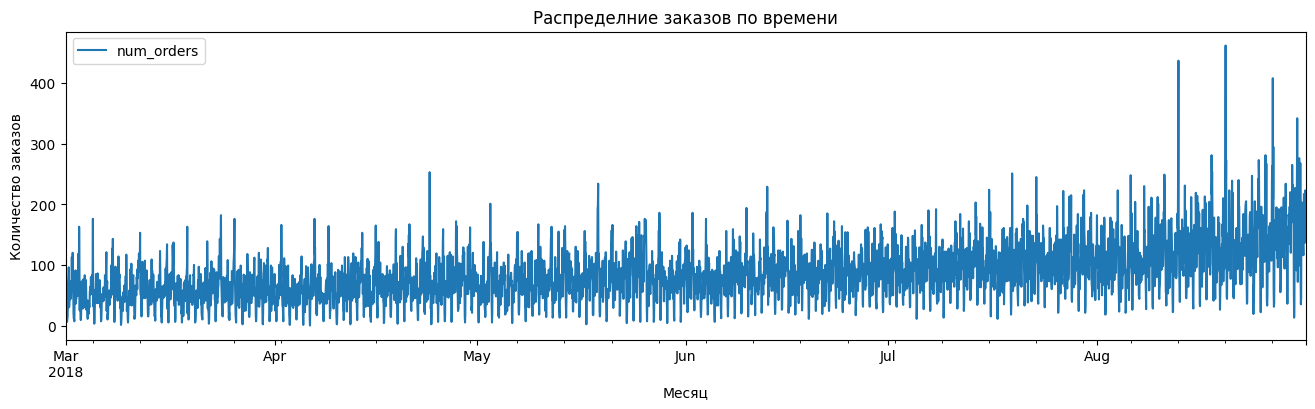

In [7]:
data.plot(figsize=(16,4), title='Распределние заказов по времени', xlabel='Месяц', ylabel='Количество заказов');


График имеет имеет большую амлитуду внутри одних суток. Это связано с временем дня. Предпологаю что заказов ночью сильно меньше. Взглянем на тренд по дням:

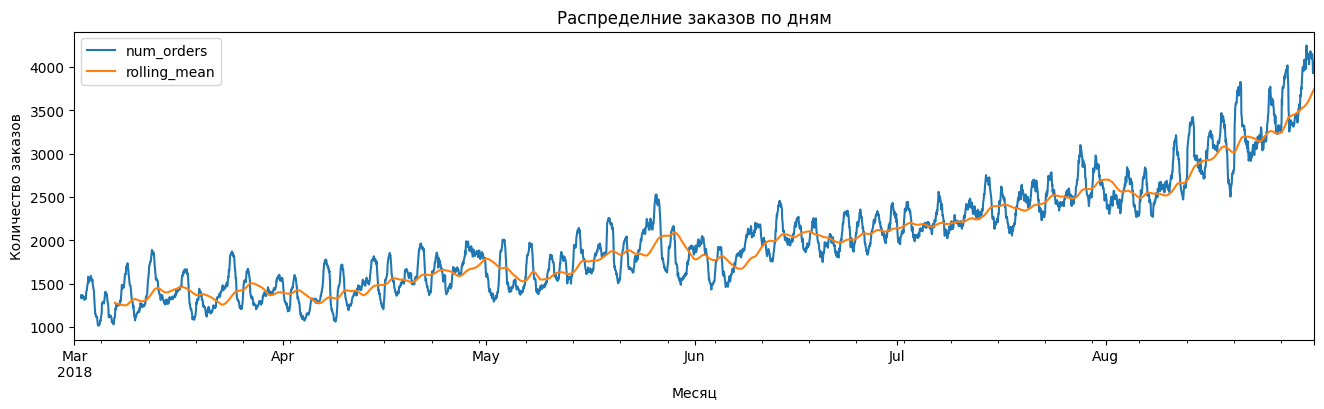

In [8]:
data['rolling_mean'] = data.rolling(120, closed='left').mean()
data.rolling(24, closed='left').sum().plot(figsize=(16,4),\
                            title='Распределние заказов по дням', xlabel='Месяц', ylabel='Количество заказов');
data = data.drop('rolling_mean', axis=1)

Здесь точно видно что у компании растет количество заказов. Следовательно временной ряд не стационарен. Является ли это просто летним ажиотажем? Ответ на вопрос остался за пределами интервала датасета. Однако стоит разложить данные на тренд и сезонность:

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

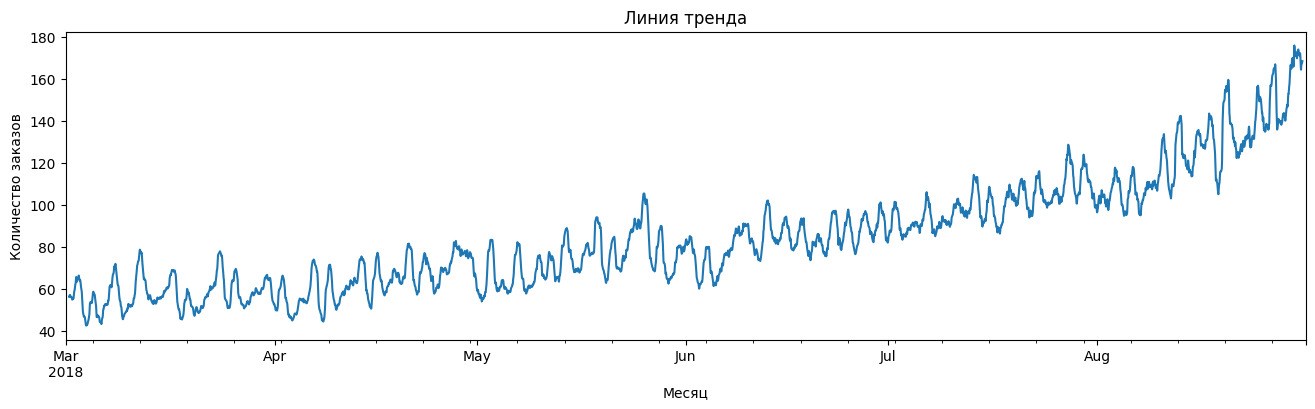

In [10]:
decomposed = seasonal_decompose(data) 
decomposed.trend.plot(figsize=(16,4), title='Линия тренда', xlabel='Месяц', ylabel='Количество заказов');

Похоже тренд как раз просматривается в суточном представлении.

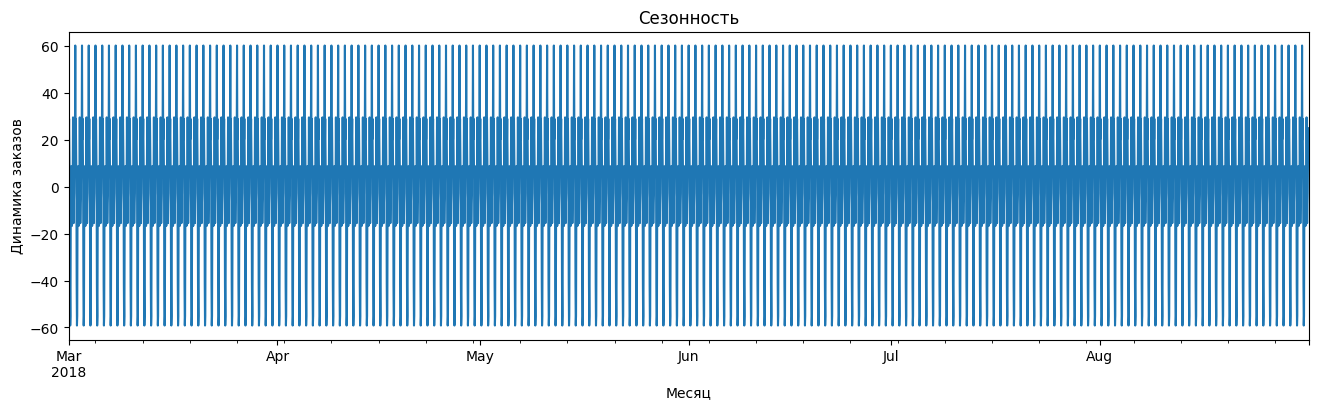

In [11]:
decomposed.seasonal.plot(figsize=(16,4), title='Сезонность', xlabel='Месяц', ylabel='Динамика заказов');

Здесь видны колебания день/ночь. Ожидаемо.

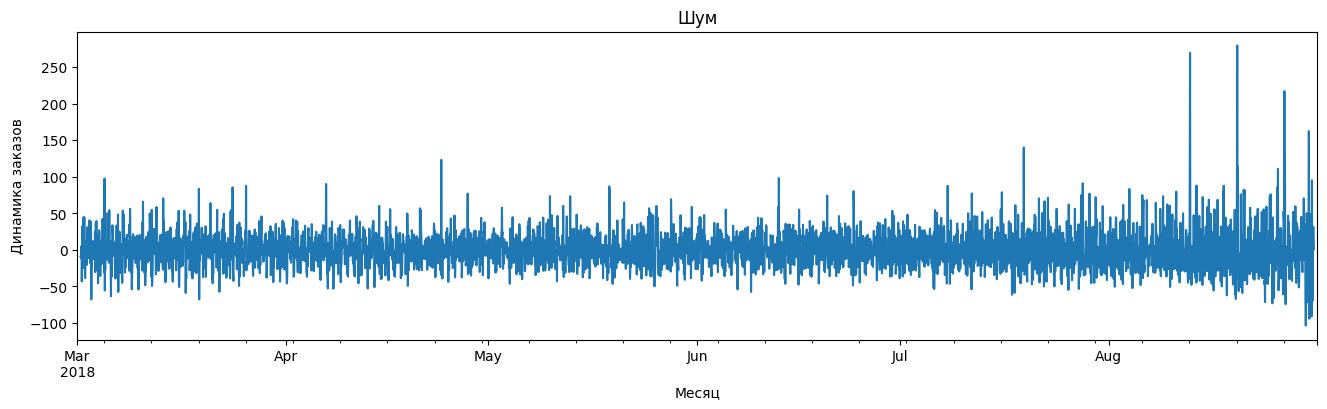

In [12]:
decomposed.resid.plot(figsize=(16,4), title='Шум', xlabel='Месяц', ylabel='Динамика заказов');

Здесь все более-менее линейно, однако есть нобъяснимые датасетом всплески. Возможно они связаны с дождливой погодой или массовыми мероприятиями.

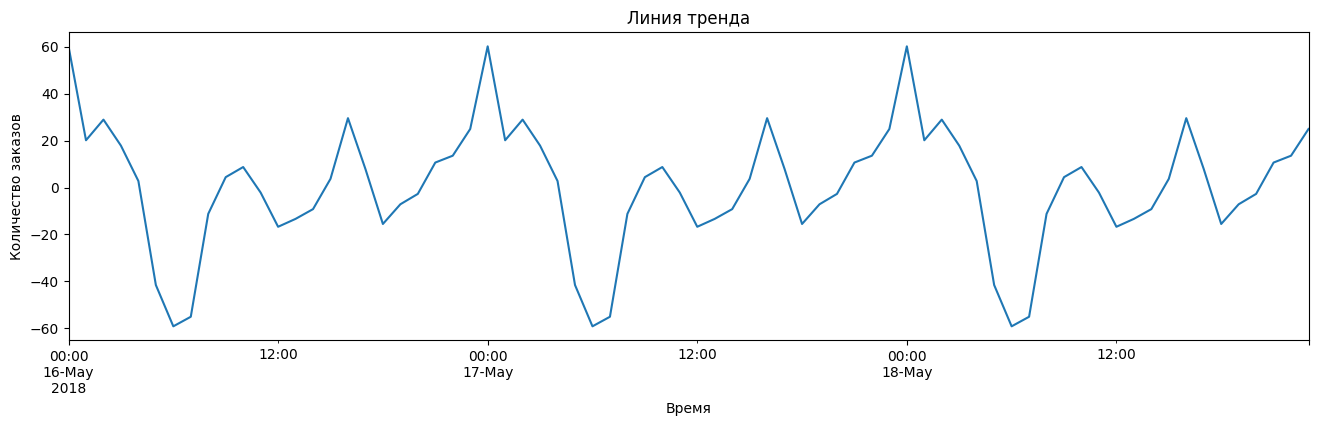

In [13]:
decomposed.seasonal['2018-05-16':'2018-05-18'].plot(figsize=(16,4), title='Линия тренда',\
                                           xlabel='Время', ylabel='Количество заказов');


Сезонность имеет суточную природу: В 6 утра происходит спад, высокая активность в 10 и 16 часов, пик активности происходит в полночь. Такое поведение может быть обусловлено пассажирским траффиком с регулярных рейсов или пересменкой персонала. 

### Вывод
В ходе анализа данных мы определили нестационарность ряда, декомпозировали на тренд и выявили суточную сезонность.

## Обучение

Добавим в датасет фичей

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, max_lag + 1):
        data['lag_' + str(i)] = data['num_orders'].shift(i)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size, closed='left').mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size, closed='left').std()
    data = data.dropna()
    return data

In [15]:
data = make_features(data, 12, 15)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
data_train, data_test = train_test_split(data, test_size=.1, shuffle=False)
print(f'Train size: {data_train.shape}, Test size: {data_test.shape}')

Xtrain, Xtest, ytrain, ytest = data_train.drop('num_orders', axis=1), data_test.drop('num_orders', axis=1),\
      data_train['num_orders'], data_test['num_orders']

Train size: (3960, 18), Test size: (440, 18)


In [18]:
#Добавим метрику
from sklearn.metrics import mean_squared_error, make_scorer
def rmse(target,predictions):
    mse = mean_squared_error(target, predictions)
    return mse ** 0.5
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [19]:
#Отскалируем признаки
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
Xtest = pd.DataFrame(scaler.transform(Xtest), index=Xtest.index, columns=Xtest.columns)

In [20]:
#Создадим и обучим модели
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as lgbm

RND_SEED = 12345

tscv = TimeSeriesSplit()
lr_model = LinearRegression(n_jobs=-1)
sgdr_model = SGDRegressor(random_state=RND_SEED)
lgb_model = lgbm.LGBMRegressor(random_state=RND_SEED)

sgdr_params = {
    'loss' : ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty' : ['l2', 'l1', 'elasticnet'],
}

lgb_params = {
    'boosting_type' : ['gbdt', 'dart'],
    'num_leaves': range(10,51,10),
    'n_estimators': range(50,251,50),
}

lr_grid = GridSearchCV(lr_model, {}, scoring=rmse_scorer, n_jobs=-1, cv=tscv)
lr_grid.fit(Xtrain, ytrain)
sgdr_grid = GridSearchCV(sgdr_model, sgdr_params, scoring=rmse_scorer, n_jobs=-1, cv=tscv)
sgdr_grid.fit(Xtrain, ytrain)
lgbm_grid = GridSearchCV(lgb_model, lgb_params, scoring=rmse_scorer, n_jobs=-1, cv=tscv)
lgbm_grid.fit(Xtrain, ytrain)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'n_estimators': range(50, 251, 50),
                         'num_leaves': range(10, 51, 10)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [21]:
results = dict()
for model, name in zip([lr_grid, sgdr_grid, lgbm_grid], ['lr', 'sgdr', 'lgbm']):
    #predictions = model.predict(Xtest)
    results[name] = {'model' : model, 'score' : -model.best_score_}
    
res = pd.DataFrame.from_dict(results, orient='index')
res

,model,score
lr,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...",32.253468
sgdr,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...",32.614112
lgbm,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...",25.026383


Мы обучили 3 модели: Линейную регрессию, Стохастический градиентный спуск и LightGBM регрессию
Перейдем к тестированию

## Тестирование

In [22]:
dummy_clf = DummyRegressor()
dummy_clf.fit(Xtrain, ytrain)
print(f'Дамми результат: {rmse(ytest, dummy_clf.predict(Xtest))}')

predictions = lgbm_grid.predict(Xtest)
print(f'Результат предсказания тестовой выборки: {rmse(ytest, predictions)}')

Дамми результат: 84.71039237247025
Результат предсказания тестовой выборки: 43.13775558025047


In [23]:
predictions_df = pd.Series(predictions)
predictions_df.index = ytest.index
predictions_df
#ytest

datetime
2018-08-13 16:00:00    154.434343
2018-08-13 17:00:00    133.062442
2018-08-13 18:00:00    111.894615
2018-08-13 19:00:00    106.240603
2018-08-13 20:00:00    115.593725
                          ...    
2018-08-31 19:00:00    128.215416
2018-08-31 20:00:00    143.638450
2018-08-31 21:00:00    137.620567
2018-08-31 22:00:00    143.144989
2018-08-31 23:00:00    162.524832
Freq: H, Length: 440, dtype: float64

Тестирование подтвердило модель LightGBM. Её RMSE составляет 43.1, что соответствует критериям проекта, а так-же проходит дамми-тестирование.

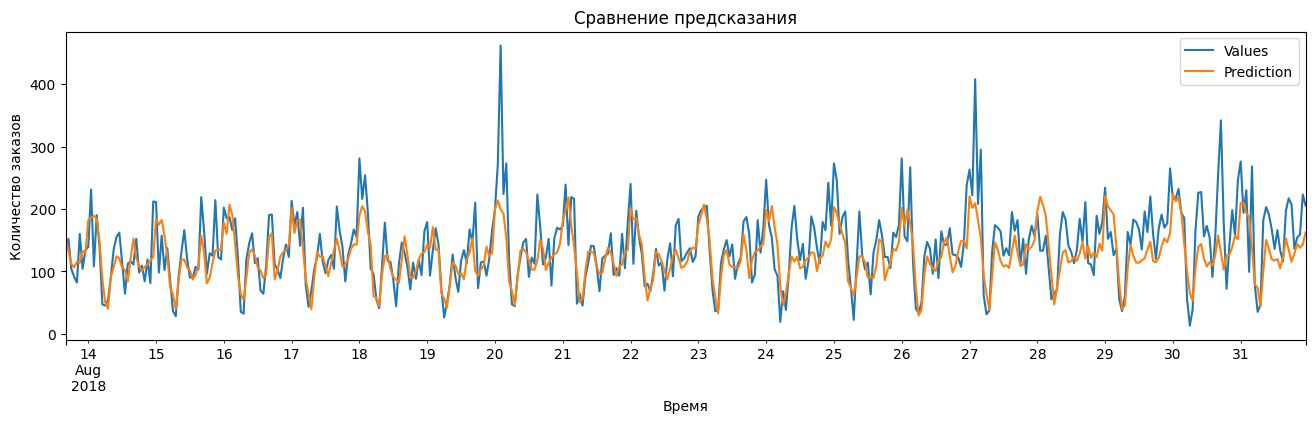

In [24]:
plot_data = pd.DataFrame([ytest, predictions_df]).T
plot_data.columns=['Values', 'Prediction']
plot_data.plot(figsize=(16,4), title='Сравнение предсказания',\
               xlabel='Время', ylabel='Количество заказов');

График показывает, что модель потеряла в точности в связи с всплесками.

## Вывод
В ходе работы мы загрузили и изучили данные, проверили дубликаты, пропуски, выбросы

Ресемплировали данные по одному часу, проперили ряд на монотонность

Проанализировали данные: посмотрели на трендовую, сезонную и шумовую составляющие данных

Подготовили и обучили модели, получили следующие оценки:

In [25]:
res

,model,score
lr,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...",32.253468
sgdr,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...",32.614112
lgbm,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...",25.026383


Проверили лучшую модель на тестовой выборке и получили RMSE 43.1, что удовлетворило требования проекта. Так-же проверили модель на адекватность.